##  Moseli Motsoehli

### Seq to Seq model for comparing text similarity.

__I use the quora question pairs dataset as a test for this although the model is eventually used for text transcribed from recorded speech as a way to evaluate  public speaking__

I reuse mose of my code from a combination of a text summarization project with Jan Platos and preprocessing from a topic modelling project for ICS661. 

In [1]:
#### Libraries
import numpy as np
import scipy as sc
from scipy.spatial.distance import cosine
import pandas as pd
import logging
from collections import Counter
from  tqdm import tqdm
from tabulate import tabulate
from Generator import *

#import gensim as gs
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelBinarizer

import os
import re
import nltk
from nltk.tokenize import word_tokenize as wt
from nltk.tokenize import sent_tokenize as st
from nltk.corpus import stopwords
nltk.download('stopwords')

import matplotlib.pyplot as plt
#import seaborn as sb

import keras
from keras.preprocessing.sequence import pad_sequences
from keras import backend as k
#k.set_learning_phase(1)
from keras import initializers
from keras.optimizers import RMSprop
from keras.models import Model,Sequential
from keras.layers import Dense,LSTM,Input,Activation,Add,TimeDistributed,\
Permute,Flatten,RepeatVector,merge,Lambda,Multiply,Reshape,Embedding,Bidirectional,Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.utils import to_categorical

#bert
from bert_embedding import BertEmbedding as Bert

#model Freezing
import tensorflow as tf
# freeze_graph "screenshots" the graph
from tensorflow.python.tools import freeze_graph
# optimize_for_inference lib optimizes this frozen graph
from tensorflow.python.tools import optimize_for_inference

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Deeps\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


## Constants

In [18]:
STRING_SIZE=15
BATCH_SIZE=32
NUM_EPOCHS = 100

## Load Dataset

In [3]:
path = "C:\\Users\\Deeps\\Documents\\School\\UH manoa\\ICS 685 Virtual and Augmented Reality\\Projects\\Untitled Folder\\quora-question-pairs\\"
datafile = "train.csv"

data =  pd.read_csv(path+datafile,sep=",")[:][:1000]
print("Number of examples: %s"%len(data))
data=data.dropna(subset=['question1','question2', 'is_duplicate'])
data=data.reset_index(drop=True)
print("Number of examples after removing NA: %s"%len(data))
print("\n")
print(data.head(2))
print("\n")
print(data.tail(2))
print("\n")
print("propotion of positives: %s"%np.mean(data["is_duplicate"]))

Number of examples: 1000
Number of examples after removing NA: 1000


   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  


      id  qid1  qid2                                          question1  \
998  998  1991  1992  Could we use cherenkov atmosphere radiation (w...   
999  999  1993  1994               What is a good song for lyric prank?   

                                             question2  is_duplicate  
998  Can we map the surface (and the subsurface) of...             1  
999                     Diving the Blue Hole in Dahab?             0  


propotion of positives: 0.38


### Preprocessing addopted from my Topic Model in ICS661 AKA Thematron

In [4]:
def remove_special(text):
    special_chars = "[~#$%^@&*&()+-_\",?!.:[]\\;><`|{}=\/\'=»¿シし]"
    for k in special_chars:
            if type(text) == str:
                if k=="-" or k=="_":
                    text=text.replace(k, "")
                else:
                    text=text.replace(k, " ")       
    return text

def contractions(sent):
    sub_pattern = [("will not","won't"),("shall not","shan't"),
                (" not", "n\'t"),(" will","\'ll"),(" is","\'s"),
                   (" am","\'m"),(" are","\'re"),(" is","who\'s")]
    sent2=sent.split(" ")
    hold = ""
    for k in range(len(sent2)):
        kk = sent2[k]
        for rep in range(len(sub_pattern)):
            kk = re.sub(sub_pattern[rep][1],sub_pattern[rep][0],kk)
        hold = hold + " " + kk
    return hold.lower()

def remove_stop_words(text):
    stops =  set(stopwords.words('english'))
    stops1 = [word.lower() for word in stops]
    punctuation = [',','.','!','?',';','-']
    hold = []
    if type(text) == list:
        for word in range(len(text)):
            if text[word].lower() in stops1 or text[word].lower() in punctuation or text[word].lower() == "xxxxxx":
                continue
            else:
                hold.append(text[word].lower())
    return hold

def wordTok(sent):
    tok = wt(sent)
    return tok

def pipeline(text):
    text = contractions(text)
    text = remove_special(text)
    textToks = wordTok(text)
    #textToks = remove_stop_words(textToks)
    final = ""
    for k in range(len(textToks)):
            final = final+textToks[k]+" "
    return final.strip().lower()

########################################################
########create corpus and create word vectors and training data###########
def createCorpus(t):
    corpus = []
    all_sent = []
    for k in t:
        for p in t[k]:
            corpus.append(st(p))
    for sent in range(len(corpus)):
        for k in corpus[sent]:
            all_sent.append(k)
    for m in range(len(all_sent)):
        all_sent[m] = wt(all_sent[m])
    
    all_words=[]
    for sent in all_sent:
        hold=[]
        for word in sent:
            hold.append(word.lower())
        all_words.append(hold)
    return all_words

def wordvecmatrix(model1,data):
    IO_data={"question1":[],"question2":[],"label":[]}
    pbar = tqdm(range(len(data["question1"])))
    for k in range(len(data["question1"])):
        q1=[]
        q2=[]
        label=[]
        for word in data["question1"][k]:
            try:
                q1.append(model1.wv.word_vec(word))
            except Exception as e:
                continue
        for word in data["question2"][k]:
            try:
                q2.append(model1.wv.word_vec(word))
            except Exception as e:
                continue
        IO_data["label"].append(data["is_duplicate"][k])
        IO_data["question1"].append(q1) 
        IO_data["question2"].append(q2)
        pbar.update(1)
    print('\007')
    pbar.close()
    return IO_data

def sequence_padding(stringlist):
    newstring = pad_sequences(stringlist, maxlen=STRING_SIZE,
                              dtype=object,padding='post',
                              truncating='post', value="PAD")
    #newstring[-1] ="#"
    return newstring

def list2string(listinput):
    hold=""
    for k in listinput:
        hold = hold +k.strip()+" "
    return hold.strip()

In [5]:
data["question1"] = list(map(pipeline,data["question1"]))
data["question2"] = list(map(pipeline,data["question2"]))


print("Show two comparison sentences")
print("--------------------------------------------")
print("1: ",data["question1"][1])
print("--------------------------------------------")
print("2: ",data["question2"][1])
print("--------------------------------------------")
print(data["is_duplicate"][1])

Show two comparison sentences
--------------------------------------------
1:  what is the story of kohinoor kohinoor diamond
--------------------------------------------
2:  what would happen if the indian government stole the kohinoor kohinoor diamond back
--------------------------------------------
0


### Corpus and Wordvectors

In [72]:
sentences1 = list(map(wordTok,data["question1"]))
sentences2 = list(map(wordTok,data["question2"]))

####Truncade and Pad to 20 words max
sentences1 = list(map(list,sequence_padding(sentences1)))
sentences2 = list(map(list,sequence_padding(sentences2)))

data["question1"] = sentences1
data["question2"] = sentences2
dataAll = [data["question1"],data["question2"]] 
dataAll = pd.concat(dataAll)

model1 = Word2Vec(size = 300,sg=1,compute_loss=True,window=4,
                 min_count=1,workers=4)
model1.build_vocab(dataAll)  # prepare the model vocabulary
model1.train(dataAll, total_examples=model1.corpus_count, epochs=100)
print(model1.get_latest_training_loss())

#model2 = Word2Vec(size = 150,sg=1,compute_loss=True,window=4,
#                 min_count=1,workers=4)
#model2.build_vocab(sentences2)  # prepare the model vocabulary
#model2.train(sentences2, total_examples=model2.corpus_count, epochs=100)
#print(model2.get_latest_training_loss())

final_data = wordvecmatrix(model1,data)
print(sentences1[2])
print(len(final_data["question1"][2]))
print(sentences2[2])
print(len(final_data["question2"][2]))
del sentences1
del sentences2
del dataAll

0.0


  0%|                                                                                          | 0/500 [00:00<?, ?it/s]




100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 5864.14it/s]


['how', 'can', 'i', 'increase', 'the', 'speed', 'of', 'my', 'internet', 'connection', 'while', 'using', 'a', 'vpn', 'PAD']
15
['how', 'can', 'internet', 'speed', 'be', 'increased', 'by', 'hacking', 'through', 'dns', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
15


In [41]:
pd.DataFrame(final_data).head(10)
#print(model1.wv.word_vec("internet"))
#print(model2.wv.word_vec("internet"))
cosine(model1.wv.word_vec("speed"),model1.wv.word_vec("men"))

0.8735039085149765

5000


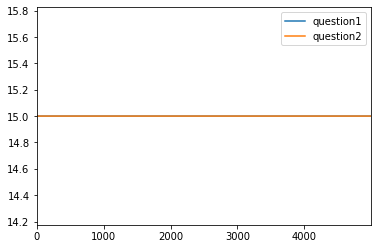

In [42]:
## implement classification using 2 inputs 1 output.
lengths = {"question1":[],"question2":[]}
for k in range(len(final_data["question1"])):
    lengths["question1"].append(len(final_data["question1"][k]))
    lengths["question2"].append(len(final_data["question2"][k]))
    
kk = pd.DataFrame(lengths)
kk.plot()
print(len(kk))

In [43]:
###Train test Split
hold = []
for k in range(len(final_data["question1"])):
    hold.append(final_data["question1"][k]+final_data["question2"][k])
len(hold[0])
final_data["combined"] = hold
del hold
x_train,x_test,y_train,y_test = tts(final_data["combined"],final_data["label"],test_size=0.3)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

lb = LabelBinarizer()
y_train= lb.fit_transform(y_train)
y_test = lb.transform(y_test)

### BERT Embeddings

In [6]:
BertVecs = Bert()

####Truncade and Pad to 20 words max
sentences1 = list(map(wordTok,data["question1"]))
sentences2 = list(map(wordTok,data["question2"]))

sentences1 = list(map(list,sequence_padding(sentences1)))
sentences2 = list(map(list,sequence_padding(sentences2)))

print(sentences1[1],"- Length: %s"%len(sentences1[1]))
print(sentences2[1],"- Length: %s"%len(sentences2[1]))

#back to sentences 
sentences1 = list(map(list2string,sentences1))
sentences2 = list(map(list2string,sentences2))
print("Examples: %s"%len(sentences2))
results1 = BertVecs(sentences1)
results2 = BertVecs(sentences2)

['what', 'is', 'the', 'story', 'of', 'kohinoor', 'kohinoor', 'diamond', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'] - Length: 15
['what', 'would', 'happen', 'if', 'the', 'indian', 'government', 'stole', 'the', 'kohinoor', 'kohinoor', 'diamond', 'back', 'PAD', 'PAD'] - Length: 15
Examples: 1000


In [7]:
data1 = [results1[k][1] for k in range(len(results1))]
data2 = [results2[k][1] for k in range(len(results2))]
len(data1[6])
#del sentences1
#del sentences2

dataall=[]
labels =[]
for k in range(len(data1)):
    if len(data1[k])>STRING_SIZE or len(data1[k])>STRING_SIZE:
        print(k)
        data1[k] = data1[k][:STRING_SIZE]
        data2[k] = data2[k][:STRING_SIZE]
        print(len(data1[k]),len(data2[k]))
    try:
        if len(data1[k])==STRING_SIZE and len(data2[k])==STRING_SIZE:
            dataall.append(np.array(data1[k]+data2[k]))
            labels.append(data["is_duplicate"][k])
        else:
            pass
    except:
        print("cant get ",k)
        print("shape : ",np.array(data1[k]).shape)
print("Final data")
print(len(dataall),len(labels))

283
15 15
Final data
999 999


In [8]:
np.array(dataall).shape

(999, 30, 768)

__Clear memory befor training__

In [9]:
del results1
del results2
del BertVecs
#del data["question1"]
#del data["question2"]

In [15]:
y= to_categorical(labels)
x_train,x_test,y_train,y_test = tts(dataall,y,test_size=0.2)
x_train,x_val,y_train,y_val = tts(x_train,y_train,test_size=0.1)

x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)


TRAIN_SIZE = len(x_train)
VAL_SIZE = len(x_val)


gentrain = get_samples(x_train,y_train,BATCH_SIZE)
gentest = get_samples(x_val,y_val,BATCH_SIZE)

In [16]:
print(x_train.shape)
print(y_train.shape)

(719, 30, 768)
(719, 2)


Results of the embedding are returned as a list of sentences and their token embeddings, so each sentence is of the form<br>
__(sentence,embeddings for each word)__

### Now Build an LSTM model with 2 inputs and one output

In [22]:
model = Sequential()
model.add(Bidirectional(LSTM(64,return_sequences=True,activation='relu',dropout=0.3)))
model.add(Dropout(0.5))
model.add(LSTM(64,return_sequences=False,activation='relu',dropout=0.3))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.compile("adam", loss ='categorical_crossentropy', metrics=['accuracy'])

print('Training...')
model.fit(x_train[:100], y_train[:100],
          epochs=1,
          verbose=1,
          batch_size=3,
          validation_split=0.2)

Training...
Train on 80 samples, validate on 20 samples
Epoch 1/1
80/80 [==============================] - ETA: 56s - loss: 0.7500 - accuracy: 0.333 - ETA: 28s - loss: 0.6641 - accuracy: 0.500 - ETA: 18s - loss: 0.5608 - accuracy: 0.666 - ETA: 13s - loss: 0.5614 - accuracy: 0.666 - ETA: 10s - loss: 0.6265 - accuracy: 0.666 - ETA: 8s - loss: 0.7901 - accuracy: 0.611 - ETA: 7s - loss: 0.8973 - accuracy: 0.52 - ETA: 6s - loss: 0.8429 - accuracy: 0.54 - ETA: 5s - loss: 0.8349 - accuracy: 0.55 - ETA: 4s - loss: 0.8722 - accuracy: 0.53 - ETA: 4s - loss: 0.8076 - accuracy: 0.57 - ETA: 3s - loss: 0.8508 - accuracy: 0.58 - ETA: 3s - loss: 1.1120 - accuracy: 0.56 - ETA: 2s - loss: 1.0813 - accuracy: 0.57 - ETA: 2s - loss: 1.1353 - accuracy: 0.57 - ETA: 2s - loss: 1.5415 - accuracy: 0.56 - ETA: 1s - loss: 1.5044 - accuracy: 0.56 - ETA: 1s - loss: 1.4738 - accuracy: 0.57 - ETA: 1s - loss: 1.4194 - accuracy: 0.57 - ETA: 1s - loss: 1.3644 - accuracy: 0.60 - ETA: 0s - loss: 1.4445 - accuracy: 0.60 - 

In [23]:
model.fit_generator(gentrain, 
                     steps_per_epoch=TRAIN_SIZE//BATCH_SIZE,
                     verbose=1,
                     validation_data=gentest,
                     validation_steps=TEST_SIZE//BATCH_SIZE,
                     epochs=NUM_EPOCHS,
                     workers=3,
                     use_multiprocessing=False)
model.save('my_model.h5')

Epoch 1/100
22/22 [==============================] - ETA: 4s - loss: 1.2250 - accuracy: 0.50 - ETA: 3s - loss: 1.1633 - accuracy: 0.50 - ETA: 3s - loss: 0.9643 - accuracy: 0.57 - ETA: 2s - loss: 0.9298 - accuracy: 0.57 - ETA: 2s - loss: 0.8830 - accuracy: 0.57 - ETA: 2s - loss: 0.8959 - accuracy: 0.56 - ETA: 2s - loss: 0.8918 - accuracy: 0.55 - ETA: 1s - loss: 0.8907 - accuracy: 0.55 - ETA: 1s - loss: 0.8733 - accuracy: 0.56 - ETA: 1s - loss: 0.8624 - accuracy: 0.55 - ETA: 1s - loss: 0.8449 - accuracy: 0.56 - ETA: 1s - loss: 0.8315 - accuracy: 0.56 - ETA: 1s - loss: 0.8182 - accuracy: 0.57 - ETA: 1s - loss: 0.8136 - accuracy: 0.56 - ETA: 0s - loss: 0.8025 - accuracy: 0.56 - ETA: 0s - loss: 0.7962 - accuracy: 0.56 - ETA: 0s - loss: 0.7887 - accuracy: 0.56 - ETA: 0s - loss: 0.7785 - accuracy: 0.57 - ETA: 0s - loss: 0.7769 - accuracy: 0.57 - ETA: 0s - loss: 0.7950 - accuracy: 0.56 - ETA: 0s - loss: 0.7914 - accuracy: 0.56 - 3s 137ms/step - loss: 0.7840 - accuracy: 0.5781 - val_loss: 0.680

In [24]:
model.evaluate(x=x_test,y=y_test,
              batch_size=BATCH_SIZE)

200/200 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 2ms/step


[0.6777810049057007, 0.6050000190734863]